## Visual Transformer + rugpt3

In [ ]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm
#Используем видеокарту
device = "cuda"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

c:\code\anaconda3\envs\transaltion\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Препроцессинг

In [3]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

c:\code\anaconda3\envs\transaltion\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Тимур\AppData\Local\Temp\ipykernel_29384\3943366170.py:11: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
C:\Users\Тимур\AppData\Local\Temp\ipykernel_29384\3943366170.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),


Модели

In [4]:
encoder_model = "google/vit-base-patch16-224"
decoder_model = "ai-forever/rugpt3small_based_on_gpt2"
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

loading configuration file config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--google--vit-base-patch16-224\snapshots\3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linne

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

loading file vocab.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\vocab.json
loading file merges.txt from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\tokenizer_config.json
loading configuration file preprocessor_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--google-

In [ ]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Код для оценки модели

In [7]:
import evaluate
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str)
    meteor_otput = meteor.compute(predictions=pred_str, references=label_str)
    bleu_otput = bleu.compute(predictions=pred_str, references=label_str)
    return {
        "rouge": round(rouge_output['rouge1'], 4),
        "meteor": round(meteor_otput['meteor'], 4),
        "bleu": round(bleu_otput['bleu'], 4),
    }

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Датасет

In [7]:
import pandas as pd

In [8]:
train_df = pd.read_parquet('train.parquet')
val_df = pd.read_parquet('val.parquet')

In [11]:
train_df.head()

,image_name,rus_cap
157875,917574521.jpg,"Две маленькие девочки стоят у стены, у одной и..."
25235,2335428699.jpg,"Пятеро детей прыгают на большой батуте, пока с..."
72550,3476957636.jpg,Мужчина в длинных шортах со множеством других ...
90485,40302299.jpg,"В коридоре стоят дети, а за ними стоят двое вз..."
81295,3671950830.jpg,Человек на синем мотоцикле с курящей задней ши...


In [12]:
len(train_df)

17557

In [35]:
train_df = train_df.sample(32)
val_df = val_df.sample(8)

In [9]:
max_length=50
import os
class Dataset:
    def __init__(self, df, tfms, root_dir='1/flickr30k_images'):
        self.df = df
        self.tfms = tfms
        self.root_dir = root_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image_name']
        caption = sample['rus_cap']
        image = os.path.join(self.root_dir, image)
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        pixel_values = augs['image']
        captions = tokenizer(caption, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        captions = [caption if caption != tokenizer.pad_token_id else -100 for caption in captions[0]]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [10]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [ ]:
num_epochs = 5
batch_size = 8 

In [16]:
for item in train_ds:
  print(item["labels"].shape)
  print(item["pixel_values"].shape)
  break

torch.Size([50])
torch.Size([3, 224, 224])


In [ ]:

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,             
    num_train_epochs=num_epochs,            
    evaluation_strategy="steps",            
    eval_steps=3148,                        
    logging_steps=3148,                     
    save_steps=3148,                        
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    output_dir="captioningv2",
)

c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [19]:
tokenizer = GPT2TokenizerFast.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')

loading file vocab.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\vocab.json
loading file merges.txt from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\tokenizer_config.json


Обучение

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,                     
    tokenizer=image_processor,       
    args=training_args,              
    compute_metrics=compute_metrics, 
    train_dataset=train_ds,     
    eval_dataset=val_ds       
)

In [21]:
trainer.train()

***** Running training *****
  Num examples = 17,557
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10,975
  Number of trainable parameters = 239,987,712
 29%|██▊       | 3148/10975 [19:30<51:11,  2.55it/s]  
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8


{'loss': 2.5463, 'grad_norm': 5.009762287139893, 'learning_rate': 3.565831435079727e-05, 'epoch': 1.43}


c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                    
 29%|██▊       | 3148/10975 [25:25<51:11,  2.55it/s]Saving model checkpoint to captioningv2\checkpoint-3148
Configuration saved in captioningv2\checkpoint-3148\config.json
Configuration saved in captioningv2\checkpoint-3148\generation_config.json


{'eval_loss': 2.4362130165100098, 'eval_rouge': 0.0001, 'eval_meteor': 0.1427, 'eval_bleu': 0.0212, 'eval_runtime': 355.1361, 'eval_samples_per_second': 12.361, 'eval_steps_per_second': 1.546, 'epoch': 1.43}


Model weights saved in captioningv2\checkpoint-3148\model.safetensors
Image processor saved in captioningv2\checkpoint-3148\preprocessor_config.json
 57%|█████▋    | 6296/10975 [46:23<30:57,  2.52it/s]     
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8
c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'loss': 1.9362, 'grad_norm': 6.440240859985352, 'learning_rate': 2.1316628701594536e-05, 'epoch': 2.87}


                                                    
 57%|█████▋    | 6296/10975 [52:16<30:57,  2.52it/s]Saving model checkpoint to captioningv2\checkpoint-6296
Configuration saved in captioningv2\checkpoint-6296\config.json
Configuration saved in captioningv2\checkpoint-6296\generation_config.json


{'eval_loss': 2.421673059463501, 'eval_rouge': 0.0, 'eval_meteor': 0.1329, 'eval_bleu': 0.0178, 'eval_runtime': 352.7325, 'eval_samples_per_second': 12.446, 'eval_steps_per_second': 1.556, 'epoch': 2.87}


Model weights saved in captioningv2\checkpoint-6296\model.safetensors
Image processor saved in captioningv2\checkpoint-6296\preprocessor_config.json
 86%|████████▌ | 9444/10975 [1:13:08<10:11,  2.50it/s]   
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8
c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'loss': 1.4783, 'grad_norm': 7.701064586639404, 'learning_rate': 6.9749430523918e-06, 'epoch': 4.3}


                                                      
 86%|████████▌ | 9444/10975 [1:18:59<10:11,  2.50it/s]Saving model checkpoint to captioningv2\checkpoint-9444
Configuration saved in captioningv2\checkpoint-9444\config.json
Configuration saved in captioningv2\checkpoint-9444\generation_config.json


{'eval_loss': 2.608138084411621, 'eval_rouge': 0.0, 'eval_meteor': 0.1262, 'eval_bleu': 0.015, 'eval_runtime': 351.1698, 'eval_samples_per_second': 12.501, 'eval_steps_per_second': 1.563, 'epoch': 4.3}


Model weights saved in captioningv2\checkpoint-9444\model.safetensors
Image processor saved in captioningv2\checkpoint-9444\preprocessor_config.json
100%|██████████| 10975/10975 [1:29:13<00:00,  2.83it/s]   Saving model checkpoint to captioningv2\checkpoint-10975
Configuration saved in captioningv2\checkpoint-10975\config.json
Configuration saved in captioningv2\checkpoint-10975\generation_config.json
Model weights saved in captioningv2\checkpoint-10975\model.safetensors
Image processor saved in captioningv2\checkpoint-10975\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 10975/10975 [1:29:19<00:00,  2.05it/s]

{'train_runtime': 5359.2628, 'train_samples_per_second': 16.38, 'train_steps_per_second': 2.048, 'train_loss': 1.8871699374466115, 'epoch': 5.0}


TrainOutput(global_step=10975, training_loss=1.8871699374466115, metrics={'train_runtime': 5359.2628, 'train_samples_per_second': 16.38, 'train_steps_per_second': 2.048, 'total_flos': 1.5842022681980436e+19, 'train_loss': 1.8871699374466115, 'epoch': 5.0})

In [12]:
model = VisionEncoderDecoderModel.from_pretrained(r"captioningv2/checkpoint-9444").to(device)

loading configuration file captioningv2/checkpoint-9444\config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "ai-forever/rugpt3small_based_on_gpt2",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 1,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_ra

In [255]:
q = train_df.sample(1)

In [256]:
print(q['image_name'], q['rus_cap'])

92140    410604272.jpg
Name: image_name, dtype: object 92140    Три человека стоят в продуктовой секции продук...
Name: rus_cap, dtype: object


In [257]:
print(q['image_name'].tolist())
print(q['rus_cap'].tolist())

['410604272.jpg']
['Три человека стоят в продуктовой секции продуктового магазина.']


In [214]:
print(q['image_name'].tolist())
print(q['rus_cap'].tolist())

['4704939783.jpg']
['Женщина в синей рубашке носит рюкзак на рынке морепродуктов, а люди заказывают рыбу за ней.']


In [177]:
val_df[val_df['image_name'] == '673806038.jpg']['rus_cap'].tolist()

['Мальчик в зеленом гидрокостюме принимает свою очередь в спринклере воды, и группа других ждет.']

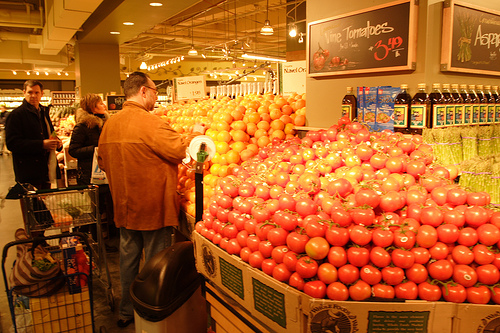

In [258]:
img =  Image.open("1/flickr30k_images/410604272.jpg").convert("RGB")
img

In [259]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"), no_repeat_ngram_size=2, num_beams=5, early_stopping=True, max_length=30, repetition_penalty=1.5)[0])
print(process_cap(generated_caption))

<s>  В продуктовом магазине женщина смотрит на фрукты и овощи на стенде Coca-Cola Adidas


In [45]:
import re
def process_cap(text):
    return re.split("[;.]", text)[0]

In [234]:
model.save_pretrained("Vit_ru_gpt2") 

Configuration saved in Vit_ru_gpt2\config.json
Configuration saved in Vit_ru_gpt2\generation_config.json
Model weights saved in Vit_ru_gpt2\model.safetensors


In [503]:
q = val_df.sample(1)

In [508]:
print(q['image_name'], q['rus_cap'])

138260    5793396150.jpg
Name: image_name, dtype: object 138260    Полицейский ездит верхом на своей лошади по го...
Name: rus_cap, dtype: object


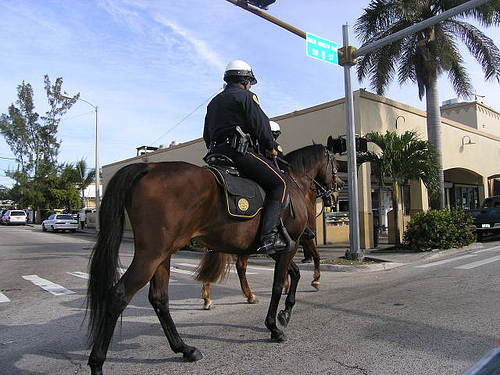

In [512]:
img =  Image.open("1/flickr30k_images/5793396150.jpg").convert("RGB")
img

In [513]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"))[0], max_length=100)
print('\033[96m' +generated_caption)

<s> Человек в черной шляпе верхом на коричневом коне с черным шлемом, черной рубашкой с


Оценка качества

In [16]:
import evaluate

In [17]:
meteor_score = evaluate.load('meteor')
bleu_score = evaluate.load('bleu')
rouge_score = evaluate.load('rouge')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
from nltk.tokenize import word_tokenize

def word_tokenize_rus(text):
    return word_tokenize(text.lower(), language='russian')

In [19]:
def eval_cap(model_name, result, original_texts):
    list_ref = [[ref] for ref in original_texts]
    bleu_results = bleu_score.compute(references=list_ref, predictions=result, tokenizer=word_tokenize_rus)
    rouge_results = rouge_score.compute(references=list_ref, predictions=result, tokenizer=word_tokenize_rus)
    meteor_results = meteor_score.compute(references=list_ref, predictions=result)
    return {'model': model_name, 'bleu': bleu_results['bleu'], 'meteor': meteor_results['meteor'],
            'rouge1': rouge_results['rouge1'], 'rouge2': rouge_results['rouge2'], 'rougeL': rouge_results['rougeL']}

In [21]:
model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [22]:
def get_captions(batch, model):
    images = batch['pixel_values'].to('cuda')
    tokens = model.generate(images, no_repeat_ngram_size=2, num_beams=5, early_stopping=True, max_length=25, repetition_penalty=1.5)
    texts = tokenizer.batch_decode(tokens, skip_special_tokens=True)

    return texts

In [23]:
from tqdm import tqdm
from torch.utils.data import DataLoader
captions = []
with torch.no_grad():
    for batch in tqdm(DataLoader(val_ds, batch_size=8, shuffle=False)):
        captions.extend(get_captions(batch, model))
        torch.cuda.empty_cache()

100%|██████████| 549/549 [13:34<00:00,  1.48s/it]


In [24]:
import re
text = 'skoepkewfvpo'
separators = "[,;|]"

result = re.split(separators, text)

In [25]:
splitted_captions = list(map(lambda x: re.split("[;.]", x)[0], captions))

In [26]:
splitted_captions[5]

'  В метро идет дождь, когда люди ходят под дождем под зонтом'

In [27]:
val_df

,image_name,rus_cap
126570,4936899101.jpg,Серьезная женщина в зеленом и в фартуке готови...
67475,336187979.jpg,"Маленькая девочка кричит с людьми, сидящими на..."
49225,2933643390.jpg,Футболисты в оранжевой форме играют с игроком ...
85210,3789230623.jpg,Двое мужчин выполняют строительные работы у ст...
152005,7575074972.jpg,"Мужчина бреет лицо другим мужчиной в том, что ..."
...,...,...
48645,2919459517.jpg,Велосипедист в сине-желтой одежде проезжает ми...
42710,2768292531.jpg,"Брюнетка, стоящая возле кафе, курит сигарету, ..."
83840,3730944181.jpg,Многие люди ходят по дороге возле нескольких б...
92835,4146537100.jpg,Мальчик в белой футболке стрижет волосы другог...


In [28]:
captions_df =pd.DataFrame( val_df['rus_cap'])
captions_df['generated'] = splitted_captions

In [29]:
captions_df.to_csv('swin_caps')

In [30]:
captions_df.head()

,rus_cap,generated
126570,Серьезная женщина в зеленом и в фартуке готови...,Азиатский мужчина в фартуке работает за прил...
67475,"Маленькая девочка кричит с людьми, сидящими на...","У ребенка на лице странное лицо, как будто о..."
49225,Футболисты в оранжевой форме играют с игроком ...,\nФутболист в красной форме пытается поймать ...
85210,Двое мужчин выполняют строительные работы у ст...,"В здании много людей, и один из них сидит на..."
152005,"Мужчина бреет лицо другим мужчиной в том, что ...","Ассист, одетый в белую рубашку, делает стриж..."


In [31]:
res_swin = eval_cap('swin', captions_df.generated.tolist(), captions_df.rus_cap.tolist())

In [32]:
res_swin

{'model': 'swin',
 'bleu': 0.01945804670076091,
 'meteor': 0.11263413410862937,
 'rouge1': 0.1708132750203696,
 'rouge2': 0.03159705514148442,
 'rougeL': 0.14725047544270498}